In [1]:
%pip install databento
%pip install backtesting
%pip install pandas_ta
%pip install vectorbt

In [2]:
import databento as db
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

# Data

In [11]:
'''client = db.Historical("db-TkdJTyWiSpJTc3Ldfs8pahy5bEhKq")
data = client.timeseries.get_range(
    start="2017-05-21",
    end="2024-02-22",
    dataset="GLBX.MDP3",
    symbols=["ES.c.0"],
    stype_in="continuous",
    stype_out="instrument_id",
    schema="ohlcv-1s",
)
df = data.to_csv("ES_M_05212017_to_02222024_test.csv")'''



'''file_data = db.DBNStore.from_file('/content/NQ.dbn.zst')
df = file_data.to_df()'''




df = pd.read_csv('/content/Advanced_Modeling_Minutes_Data.csv')



#df = df.to_csv("NQ_Advanced_Modeling_Minutes_Data.csv")


columns_to_drop = ['rtype', 'publisher_id', 'instrument_id', 'symbol']
df.drop(columns=columns_to_drop, inplace=True)
df = df.rename({'open': 'Open', 'high': 'High' , 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, axis='columns')

df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Volume'] = df['Volume'].astype(float)



#df = df.between_time('09:00:00', '12:00:00')
df = df.iloc[4735:8423]
df = df.reset_index(drop=True)
df
#df.insert(0, None, df.index)
#df.plot()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ts_event,Open,High,Low,Close,Volume
0,2023-12-06 21:58:00+00:00,4556.75,4557.00,4556.75,4556.75,188.0
1,2023-12-06 21:59:00+00:00,4556.75,4556.75,4556.25,4556.50,271.0
2,2023-12-06 23:00:00+00:00,4556.00,4556.50,4552.50,4553.25,1474.0
3,2023-12-06 23:01:00+00:00,4553.25,4554.75,4553.25,4554.25,613.0
4,2023-12-06 23:02:00+00:00,4554.25,4555.25,4554.25,4554.75,245.0
...,...,...,...,...,...,...
3683,2023-12-11 14:27:00+00:00,4602.25,4602.25,4601.25,4602.00,657.0
3684,2023-12-11 14:28:00+00:00,4601.75,4601.75,4600.75,4601.75,1032.0
3685,2023-12-11 14:29:00+00:00,4601.50,4602.75,4601.25,4602.25,1814.0
3686,2023-12-11 14:30:00+00:00,4602.25,4604.25,4600.50,4601.00,8323.0


# Rolling Window

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


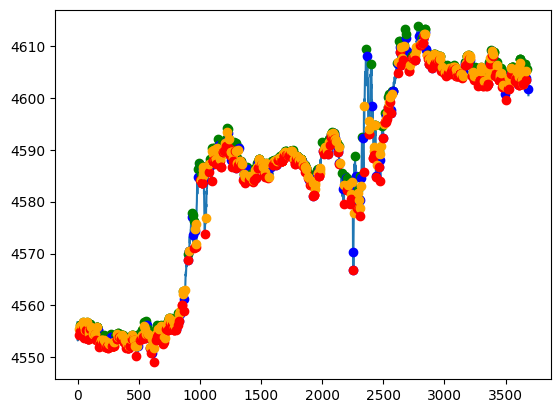

[[30, 24, 4556.25, 4555.5], [44, 38, 4556.5, 4556.0], [54, 48, 4556.75, 4554.0], [75, 69, 4556.5, 4555.75], [76, 70, 4556.5, 4555.5], [85, 79, 4556.75, 4553.5], [106, 100, 4556.5, 4555.75], [108, 102, 4556.5, 4555.75], [129, 123, 4555.0, 4554.75], [131, 125, 4555.0, 4554.75], [140, 134, 4555.75, 4554.5], [148, 142, 4555.25, 4554.0], [164, 158, 4555.75, 4555.25], [165, 159, 4555.75, 4554.5], [166, 160, 4555.75, 4554.5], [168, 162, 4555.75, 4555.25], [193, 187, 4553.5, 4553.5], [195, 189, 4553.5, 4553.5], [199, 193, 4553.5, 4553.5], [200, 194, 4553.5, 4553.5], [211, 205, 4554.0, 4553.0], [222, 216, 4554.25, 4552.75], [238, 232, 4552.75, 4552.5], [248, 242, 4553.0, 4552.5], [249, 243, 4553.0, 4552.25], [276, 270, 4554.5, 4554.0], [319, 313, 4554.25, 4553.75], [320, 314, 4554.25, 4553.5], [321, 315, 4554.25, 4553.75], [322, 316, 4554.25, 4553.5], [323, 317, 4554.25, 4553.75], [324, 318, 4554.25, 4554.0], [336, 330, 4554.75, 4554.5], [337, 331, 4554.75, 4554.25], [349, 343, 4554.5, 4553.75]

In [12]:
# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break

    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break

    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            # top[3] = price of confirmation index
            top = [i, i - order, data[i - order], data[i]]
            tops.append(top)

        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            # bottom[3] = price of confirmation index
            bottom = [i, i - order, data[i - order], data[i]]
            bottoms.append(bottom)

    return tops, bottoms



tops, bottoms = rw_extremes(df['Close'].to_numpy(), 6)
df['Close'].plot()
idx = df.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')
    plt.plot(idx[top[0]], top[3], marker='o', color='blue')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')
    plt.plot(idx[bottom[0]], bottom[3], marker='o', color='orange')



#plt.xlim(80, 200)
#plt.ylim(4555, 4565)
plt.show()
print(tops)
print(bottoms)

# Directional Change

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


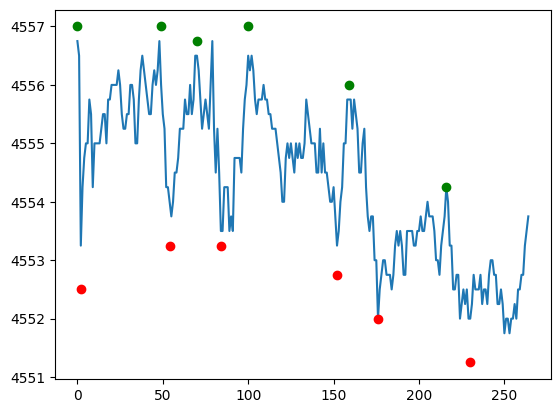

[[2, 0, 4557.0], [52, 49, 4557.0], [81, 70, 4556.75], [118, 100, 4557.0], [170, 159, 4556.0], [224, 216, 4554.25]]
[[4, 2, 4552.5], [63, 54, 4553.25], [98, 84, 4553.25], [156, 152, 4552.75], [216, 176, 4552.0], [263, 230, 4551.25]]


In [5]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):

    up_zig = True # Last extreme is a bottom. Next is a top.
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig: # Last extreme is a bottom
            if high[i] > tmp_max:
                # New high, update
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma:
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # Last extreme is a top
            if low[i] < tmp_min:
                # New low, update
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma:
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms



def get_extremes(ohlc: pd.DataFrame, sigma: float):
    tops, bottoms = directional_change(ohlc['Close'].to_numpy(), ohlc['High'].to_numpy(), ohlc['Low'].to_numpy(), sigma)
    tops = pd.DataFrame(tops, columns=['conf_i', 'ext_i', 'ext_p'])
    bottoms = pd.DataFrame(bottoms, columns=['conf_i', 'ext_i', 'ext_p'])
    tops['type'] = 1
    bottoms['type'] = -1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('conf_i')
    extremes = extremes.sort_index()
    return extremes





tops, bottoms = directional_change(df['Close'].to_numpy(), df['High'].to_numpy(), df['Low'].to_numpy(), 0.00045) # 0.0017
extremes = get_extremes(df, 0.00045)




df['Close'].plot()
idx = df.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')


#plt.xlim(60, 90)
#plt.ylim(2400, 2498)
plt.show()
#print(extremes)
print(tops)
print(bottoms)

# Perceptually Important Points

In [6]:
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):

        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):

                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y





i = 5
points = 1
x = df['Close'].iloc[i-40:i].to_numpy()
pips_x, pips_y = find_pips(x, points, 1)

pd.Series(x).plot()
for i in range(points):
    plt.plot(pips_x[i], pips_y[i], marker='o', color='red')

plt.show()
print(pips_x)
print(pips_y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: index 0 is out of bounds for axis 0 with size 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


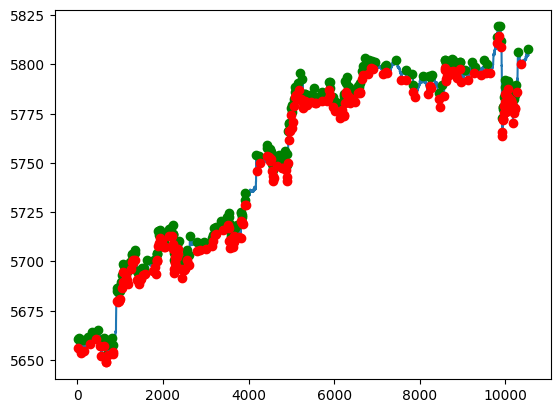

[[12, 7, 5660.5], [59, 48, 5661.0], [132, 123, 5660.25], [290, 254, 5661.5], [415, 351, 5664.0], [513, 472, 5665.25], [547, 539, 5660.0], [621, 614, 5661.0], [650, 640, 5660.75], [679, 673, 5652.75], [705, 696, 5657.75], [821, 819, 5661.25], [837, 833, 5657.75], [925, 924, 5685.0], [939, 933, 5686.5], [953, 952, 5684.5], [963, 962, 5687.25], [980, 978, 5686.5], [1003, 1002, 5685.0], [1036, 1011, 5689.5], [1057, 1051, 5693.25], [1074, 1068, 5698.5], [1094, 1078, 5697.5], [1146, 1144, 5696.25], [1172, 1165, 5694.5], [1252, 1238, 5699.5], [1277, 1273, 5704.0], [1290, 1285, 5703.25], [1306, 1300, 5704.0], [1337, 1336, 5704.25], [1354, 1350, 5705.75], [1395, 1392, 5695.0], [1445, 1413, 5694.0], [1469, 1462, 5695.25], [1475, 1473, 5694.0], [1528, 1516, 5696.5], [1572, 1554, 5696.75], [1730, 1631, 5700.5], [1802, 1792, 5700.75], [1818, 1816, 5700.75], [1853, 1852, 5704.0], [1856, 1855, 5704.25], [1863, 1861, 5703.75], [1885, 1884, 5715.25], [1905, 1901, 5713.25], [1920, 1914, 5715.5], [1937, 

,ts_event,Open,High,Low,Close,Volume,Ext_I,Ext_P,Type
0,2017-05-21 22:00:00+00:00,5652.75,5654.50,5651.25,5654.00,182.0,0.0,0.0,0.0
1,2017-05-21 22:01:00+00:00,5654.00,5655.00,5653.75,5654.75,87.0,0.0,0.0,0.0
2,2017-05-21 22:02:00+00:00,5654.75,5657.00,5654.50,5656.75,132.0,0.0,0.0,0.0
3,2017-05-21 22:03:00+00:00,5656.75,5659.50,5656.25,5659.25,171.0,0.0,0.0,0.0
4,2017-05-21 22:04:00+00:00,5659.00,5659.00,5657.75,5658.25,96.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10535,2017-06-01 01:30:00+00:00,5804.00,5805.25,5804.00,5805.25,53.0,0.0,0.0,0.0
10536,2017-06-01 01:31:00+00:00,5805.25,5805.50,5805.00,5805.00,19.0,0.0,0.0,0.0
10537,2017-06-01 01:32:00+00:00,5805.00,5805.25,5804.50,5805.25,39.0,0.0,0.0,0.0
10538,2017-06-01 01:33:00+00:00,5805.50,5805.75,5804.75,5804.75,40.0,0.0,0.0,0.0


In [ ]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):

    up_zig = True # Last extreme is a bottom. Next is a top.
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig: # Last extreme is a bottom
            if high[i] > tmp_max:
                # New high, update
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma:
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # Last extreme is a top
            if low[i] < tmp_min:
                # New low, update
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma:
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms



def get_extremes_dr(ohlc: pd.DataFrame, sigma: float):
    tops, bottoms = directional_change(ohlc['Close'].to_numpy(), ohlc['High'].to_numpy(), ohlc['Low'].to_numpy(), sigma)
    tops = pd.DataFrame(tops, columns=['Conf_I', 'Ext_I', 'Ext_P'])
    bottoms = pd.DataFrame(bottoms, columns=['Conf_I', 'Ext_I', 'Ext_P'])
    tops['Type'] = -1
    bottoms['Type'] = 1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('Conf_I')
    extremes = extremes.sort_index()
    return extremes





tops, bottoms = directional_change(df['Close'].to_numpy(), df['High'].to_numpy(), df['Low'].to_numpy(), 0.00045) #0.005
extremes_dr = get_extremes_dr(df, 0.00045) #0.005


#df = pd.concat([df, extremes], axis=1
df = pd.merge(df, extremes_dr, left_index=True, right_index=True, how='left')
df = df.fillna(0)



# Printing/Plotting ----------------------------------------------------------------------------
df['Close'].plot()
idx = df.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')


#plt.xlim(60, 90)
#plt.ylim(2400, 2498)
plt.show()

#print(df)
'''print("df info:")
print(df.info())

print("\nextremes info:")
print(extremes_dr.info())'''

#extremes_dr
print(tops)
print(bottoms)
df
#df = df.to_csv("new_combined_2.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


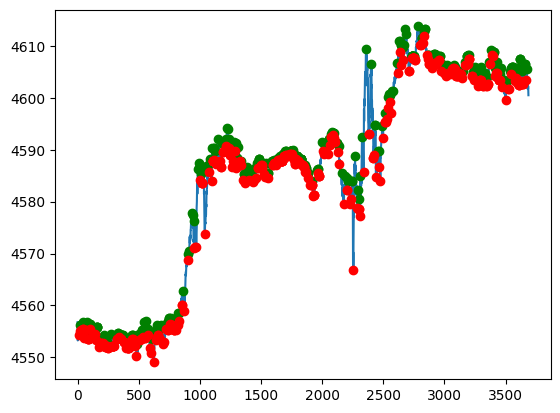

[[30, 24, 4556.25], [44, 38, 4556.5], [54, 48, 4556.75], [75, 69, 4556.5], [76, 70, 4556.5], [85, 79, 4556.75], [106, 100, 4556.5], [108, 102, 4556.5], [129, 123, 4555.0], [131, 125, 4555.0], [140, 134, 4555.75], [148, 142, 4555.25], [164, 158, 4555.75], [165, 159, 4555.75], [166, 160, 4555.75], [168, 162, 4555.75], [193, 187, 4553.5], [195, 189, 4553.5], [199, 193, 4553.5], [200, 194, 4553.5], [211, 205, 4554.0], [222, 216, 4554.25], [238, 232, 4552.75], [248, 242, 4553.0], [249, 243, 4553.0], [276, 270, 4554.5], [319, 313, 4554.25], [320, 314, 4554.25], [321, 315, 4554.25], [322, 316, 4554.25], [323, 317, 4554.25], [324, 318, 4554.25], [336, 330, 4554.75], [337, 331, 4554.75], [349, 343, 4554.5], [358, 352, 4554.0], [368, 362, 4554.25], [369, 363, 4554.25], [370, 364, 4554.25], [378, 372, 4554.25], [390, 384, 4554.0], [412, 406, 4552.75], [428, 422, 4552.5], [430, 424, 4552.5], [454, 448, 4554.25], [455, 449, 4554.25], [456, 450, 4554.25], [493, 487, 4552.5], [510, 504, 4554.5], [517

,ts_event,Open,High,Low,Close,Volume,Ext_I,Ext_P,Type
0,2023-12-06 21:58:00+00:00,4556.75,4557.00,4556.75,4556.75,188.0,0.0,0.0,0.0
1,2023-12-06 21:59:00+00:00,4556.75,4556.75,4556.25,4556.50,271.0,0.0,0.0,0.0
2,2023-12-06 23:00:00+00:00,4556.00,4556.50,4552.50,4553.25,1474.0,0.0,0.0,0.0
3,2023-12-06 23:01:00+00:00,4553.25,4554.75,4553.25,4554.25,613.0,0.0,0.0,0.0
4,2023-12-06 23:02:00+00:00,4554.25,4555.25,4554.25,4554.75,245.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3683,2023-12-11 14:27:00+00:00,4602.25,4602.25,4601.25,4602.00,657.0,0.0,0.0,0.0
3684,2023-12-11 14:28:00+00:00,4601.75,4601.75,4600.75,4601.75,1032.0,0.0,0.0,0.0
3685,2023-12-11 14:29:00+00:00,4601.50,4602.75,4601.25,4602.25,1814.0,0.0,0.0,0.0
3686,2023-12-11 14:30:00+00:00,4602.25,4604.25,4600.50,4601.00,8323.0,0.0,0.0,0.0


In [13]:
# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break

    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break

    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)

        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)

    return tops, bottoms



'''tops, bottoms = rw_extremes(df['Close'].to_numpy(), 500)
df['Close'].plot()
idx = df.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')'''

#plt.xlim(10, 67)
#plt.ylim(5017, 5018.5)
#plt.show()
#print(tops)
#print(bottoms)


def get_extremes_rw(ohlc: pd.DataFrame, order: int):
    tops, bottoms = rw_extremes(ohlc['Close'].to_numpy(), order)
    tops = pd.DataFrame(tops, columns=['Conf_I', 'Ext_I', 'Ext_P'])
    bottoms = pd.DataFrame(bottoms, columns=['Conf_I', 'Ext_I', 'Ext_P'])
    tops['Type'] = -1
    bottoms['Type'] = 1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('Conf_I')
    extremes = extremes.sort_index()
    return extremes





tops, bottoms = rw_extremes(df['Close'].to_numpy(), 6)
extremes_rw = get_extremes_rw(df, 6)

df = pd.concat([df, extremes_rw], axis=1)
df = df.fillna(0)




# Printing/Plotting ----------------------------------------------------------------------------
df['Close'].plot()
idx = df.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')

'''print("df info:")
print(df.info())

print("\nextremes info:")
print(extremes_rw.info())'''

#plt.xlim(0, 1000)
#plt.ylim(5010, 5020)
plt.show()
#extremes_rw
print(tops)
print(bottoms)
df
#df = df.to_csv("testing_combine_df.csv")


In [14]:
def SIGNAL():
  return df.Type


def STOP_LOSS():
  return df.Ext_P


#df[df.Ext_P != 0].head(20)
#df
#df_i

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Backtesting.py

In [15]:
from backtesting import Backtest, Strategy
from backtesting.lib import TrailingStrategy


class ExtremeStrategy(TrailingStrategy): # Strategy

    def init(self):
        super().init()
        super().set_trailing_sl(2)
        self.signal = self.I(SIGNAL)
        self.stop_loss = self.I(STOP_LOSS)
        self.epsilon = 0.00001

    def next(self):
        super().next()

        if self.data['Type'] == 1 and len(self.trades)==0:   # and len(self.trades)==0
            price = self.data.Close[-1]
            #stpl = (price - self.data['Ext_P'])*0.75 + self.data['Ext_P'] stpl = self.data['Ext_P']
            stpl = self.data['Ext_P']
            tpl = (price - stpl)*4 + price
            self.buy(sl = stpl-self.epsilon) # self.buy(sl = stpl-self.epsilon , tp = tpl+self.epsilon)

        elif self.data['Type']== -1 and len(self.trades)==0: # and len(self.trades)==0
            price = self.data.Close[-1]
            #stpl = (self.data['Ext_P'] - price)*0.75+ price stpl = self.data['Ext_P']
            stpl = self.data['Ext_P']
            tpl = price - (stpl - price)*4
            self.sell(sl = stpl+self.epsilon) # self.sell(sl = stpl+self.epsilon, tp = tpl-self.epsilon)



bt = Backtest(df, ExtremeStrategy, cash=1_000_000, exclusive_orders=True)
output = bt.run()
bt.plot()
print(output)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-15-edad4b87ad08>:33: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, ExtremeStrategy, cash=1_000_000, exclusive_orders=True)
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                                     0.0
End                                    3687.0
Duration                               3687.0
Exposure Time [%]                   77.603037
Equity Final [$]                1000605.14829
Equity Peak [$]                  1004376.6365
Return [%]                           0.060515
Buy & Hold Return [%]                0.960114
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.519153
Avg. Drawdown [%]                   -0.085924
Max. Drawdown Duration                 2334.0
Avg. Drawdown Duration                 182.15
# Trades                                233.0
Win Rate [%]                        31.759657
Best Trade [%]                       0.243261
Worst Trade [%]                     -0.109908
Avg. Trade [%]                    

# Vectorbt

In [16]:
# Work on it
'''import vectorbt as vbt

ind_rw = vbt.IndicatorFactory(
    class_name="Roliing Window",
    short_name="RW",
    input_names=["df"],
    param_names = ["window"],
    output_names=["extremes"],
    ).from_apply_func(
           get_extremes_rw,
           window=6
           )

res_rw = ind_rw.run(df["Close"],
                    window = [5,6,7],
                    param_product = True
                    )



pf = vbt.Portfolio.from_signals(
    df['Close'],
    entries,
    exits,
    init_cash=1000000,
    sl_stop=df['sl'],
    tp_stop=df['tp']
)


pf.plot().show()
print(pf.stats())'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'import vectorbt as vbt\n\nind_rw = vbt.IndicatorFactory(\n    class_name="Roliing Window",\n    short_name="RW",\n    input_names=["df"],\n    param_names = ["window"],\n    output_names=["extremes"],\n    ).from_apply_func(\n           get_extremes_rw,\n           window=6\n           )\n\nres_rw = ind_rw.run(df["Close"],\n                    window = [5,6,7],\n                    param_product = True\n                    )\n\n\n\npf = vbt.Portfolio.from_signals(\n    df[\'Close\'],\n    entries,\n    exits,\n    init_cash=1000000,\n    sl_stop=df[\'sl\'],\n    tp_stop=df[\'tp\']\n)\n\n\npf.plot().show()\nprint(pf.stats())'